In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import perfplot

In [49]:
def matrix_intervals(m, axis=1):
    """Turn a matrix to row(column)-wise intervals
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
    """
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    # create intrvals around the diagonal terms
    return np.array([ (d-r, d+r) for d, r in zip(ds, rs) ])

#
# a = np.arange(0,9).reshape((3,3))
# assert np.all(matrix_intervals(a,1) == np.array([[-3,  3],
#                                                  [-4, 12],
#                                                  [-5, 21]]))
# assert np.all(matrix_intervals(a,0) == np.array([[-9,  9],
#                                                  [-4, 12],
#                                                  [ 1, 15]]))


def alg1(m, axis=1):
    """Specifies the stabaility property of the matrix.
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
       return:
               0 - super-stable
               1 - inconclusive
               2 - unstable
    
    """
    n = m.shape[0]
    intervals = matrix_intervals(m,axis)
    us = np.array([u for _,u in intervals])
    ls = np.array([l for l,_ in intervals])
    u_max_index = np.argmax(us)
    u_max = us[u_max_index]    
    if u_max < 0:# Super-stable
        return 0
    
    l_i = ls[u_max_index] 
    if l_i < 0:# Inconclusive
        return 1
    indices = [i for i in range(0, n) if i != u_max_index]
    for j in indices:
        l_j, u_j = ls[j], us[j]
        if l_i < u_j:
            if l_j < l_i:
                l_i = l_j
            if l_i < 0:# Inconclusive
                return 1
    return 2# unstable            

def alg2(m, axis=1):
    """Specifies if the stabaility property can be tightened.
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
       return:
               0 - super-stable
               1 - inconclusive
               2 - unstable
    
    """
    n = m.shape[0]
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    a_max_index = np.argmax(ds)
    a_ii = ds[a_max_index]
    r_i = rs[a_max_index]
    indices = [i for i in range(0, n) if i != a_max_index]
    if a_ii > 0:        
        for j in indices:
            r_j = rs[j]
            a_jj = m[j,j]
            if axis == 0:
                a_ji = m[j, a_max_index]
            else:
                a_ji = m[a_max_index, j]
            c_0 = r_i
            c_1 = a_jj-a_ii+r_j-np.abs(a_ji)
            c_2 = np.abs(a_ji)                        
            d_max = np.real(np.max(np.roots([c_2, c_1, c_0])))
            if d_max <= r_i/a_ii:
                return 1 # Inconclusive
            if c_1 >= 0:                
                return 1 # Inconclusive
            if c_1*c_1 <= 4*np.abs(a_ji*r_i):                
                return 1 # Inconclusive
        return 2 # Unstable
    else:
        #r_j = rs[j]
        #a_jj = m[j,j]
        #a_ji = m[j, a_max_index]
        #if r_i/np.abs(a_ii) >= np.min([ (np.abs(a_jj)-r_j)/np.abs(a_ji)  for j in indices]):
        # select r_i, a_jj and a_ji
        if axis == 0:
            parts = [(rs[j], m[j,j], m[j, a_max_index]) for j in indices]
        else:
            parts = [(rs[j], m[j,j], m[a_max_index, j]) for j in indices]
        values = [(np.abs(a_jj)-r_j)/np.abs(a_ji)  for (r_j, a_jj, a_ji) in parts]
        if r_i/np.abs(a_ii) >= np.min(values):
            return 1 # Inconclusive
        return 0 # Super-stable

def alg(m):
    ret = alg1(m, axis = 0)
    if ret != 1:
        return ret
    ret = alg1(m, axis = 1)
    if ret != 1:
        return ret
    ret = alg2(m, axis = 0)
    if ret != 1:
        return ret
    return alg2(m, axis = 1)

In [3]:
sp.__version__

'1.11.3'

In [50]:
def is_unstable(m):
    """Find the linear stability of a matrix"""
    return np.any(np.real(sp.linalg.eigvals(m)) > 0)

Output()

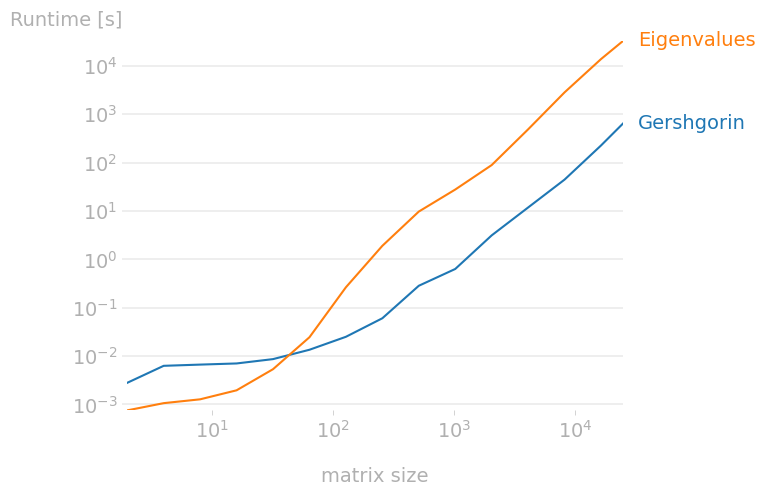

In [4]:
samples_n = 30


perfplot.show(
    setup=lambda n: [np.random.normal(0, np.random.uniform(.1, 1), (n,n)) - (n/10)*np.eye(n) 
                     for _ in range(samples_n//3)] + 
                    [np.random.normal(0, np.random.uniform(.1, 1), (n,n))  
                     for _ in range(samples_n//3)] + 
                    [np.random.normal(0, np.random.uniform(.1, 1), (n,n)) + (n/10)*np.eye(n) 
                     for _ in range(samples_n//3)],
    kernels=[
        lambda ms: [alg(m) for m in ms],
        lambda ms: [is_unstable(m) for m in ms],
    ],
    labels=["Gershgorin", "Eigenvalues"],
    n_range=[2**k for k in range(1, 15)] +[25000] ,#[2**k for k in range(25)],
    xlabel="matrix size",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
     equality_check=None,#np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

16384

In [170]:
def sample_matrix2(n = 4, L = 1.5, sigma = 1.0):
    off_diags = np.random.uniform(0.0, .5, size=n-2 ).tolist()    #np.random.normal(0.0, .5, size=n-2 ).tolist()    
    last_term = max(0, L - np.sum(np.abs(off_diags)))
    row1  = np.array([-1] + off_diags + [last_term])
    
    m = np.diag( [-1] + np.random.normal( np.random.uniform(-45, -10) , sigma, size=n-1 ).tolist())
    
    def off_diags(i):
        off_d = np.random.normal(0.0, sigma, size=n-1 ).tolist()
        return off_d[:i] + [m[i,i]] + off_d[i:]
    m = np.vstack([row1, np.array([ off_diags(i)  for i in range(1, n)])])
    return m
    

def sample_matrix(n = 4, L = 1.5, sigma = 1.0):
    m = np.diag( [-1] + np.random.normal( np.random.uniform(-10, 0.5) , sigma, size=n-1 ).tolist())
    
    def off_diags(i):
        off_d = np.random.uniform(0.0, sigma, size=n-1 ).tolist() #np.random.normal(0.0, sigma, size=n-1 ).tolist()
        return off_d[:i] + [m[i,i]] + off_d[i:]
    m = np.array([ off_diags(i)  for i in range(n)])
    
    return m

In [197]:
def is_inside_the_circle(m, mu = -1, L = 1.5):
    eigens = sp.linalg.eigvals(m)
    dists = [np.sqrt( (np.real(e) - mu)**2 + np.imag(e)**2) - L  for e in eigens]
    i = np.argmin(dists)
#     if dists[i] > 0:
#         print(dists, i)
#         raise ValueError(m, eigens)
    return eigens[i], eigens,dists[i] < 0 
    
repeats = 1000000
#eigen_values, all_eigens = np.array([ is_inside_the_circle(sample_matrix( L = 1.5, sigma = 1.0),L = 1.5) for _ in range(repeats)])
eigen_values, all_eigens = [], []
for i in range(repeats):
    e, e_all, is_valid = is_inside_the_circle(sample_matrix2( L = 1.5, sigma = 4.0),L = 1.5)
    if is_valid:
        eigen_values.append(e)
        all_eigens.append(e_all)
    
eigen_values = np.array(eigen_values)
all_eigens = np.array(all_eigens)

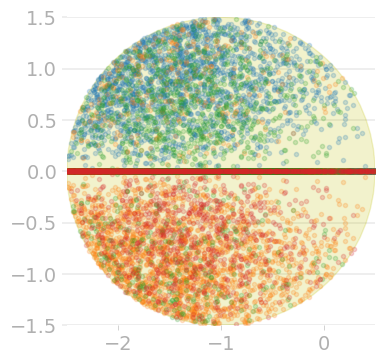

In [198]:
fig = plt.figure(figsize=(12,4))
ax = fig.subplots() 
circle1 = plt.Circle((-1, 0), 1.5, color='y', alpha=.2)
ax.add_patch(circle1)

# xs = np.real(eigen_values)
# ys = np.imag(eigen_values)
# ax.scatter(xs, ys, alpha=.2)

for i in range(4):
    xs = np.real(all_eigens[:, i])
    ys = np.imag(all_eigens[:, i])
    flg = np.sqrt( (xs+1.)**2 + ys**2)
    ax.scatter([xs[i] for i in range(xs.shape[0]) if flg[i] < 1.5], 
               [ys[i] for i in range(xs.shape[0]) if flg[i] < 1.5], 
               marker='.', alpha=.2)

    
ax.set_aspect('equal', adjustable='box')

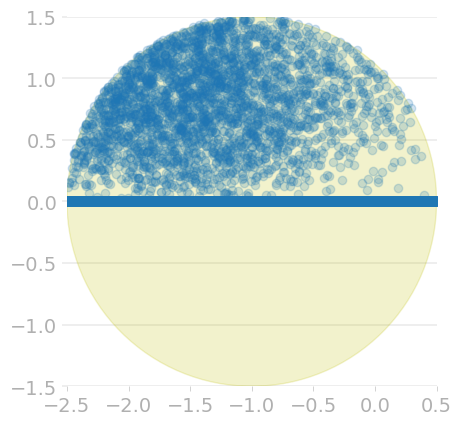

In [199]:
xs = np.real(eigen_values)
ys = np.imag(eigen_values)

fig, ax = plt.subplots() 
circle1 = plt.Circle((-1, 0), 1.5, color='y', alpha=.2)
ax.add_patch(circle1)
ax.scatter(xs, ys, alpha=.2)
ax.set_aspect('equal', adjustable='box')

(array([ 18070.,  35119.,  75037., 157511., 240200., 209851., 113401.,
         52312.,  24932.,  13491.,   8015.,   4805.,   3149.,   2123.,
          1503.,   1012.,    724.,    540.,    422.]),
 array([-1.5       , -1.39473684, -1.28947368, -1.18421053, -1.07894737,
        -0.97368421, -0.86842105, -0.76315789, -0.65789474, -0.55263158,
        -0.44736842, -0.34210526, -0.23684211, -0.13157895, -0.02631579,
         0.07894737,  0.18421053,  0.28947368,  0.39473684,  0.5       ]),
 <BarContainer object of 19 artists>)

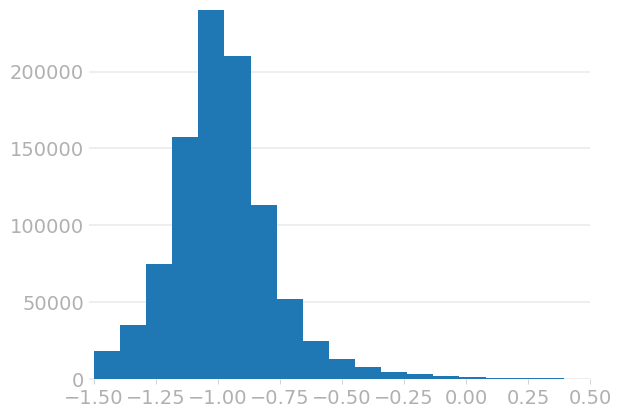

In [200]:
plt.hist(np.real(eigen_values), bins=np.linspace(-1.5, .5, 20))

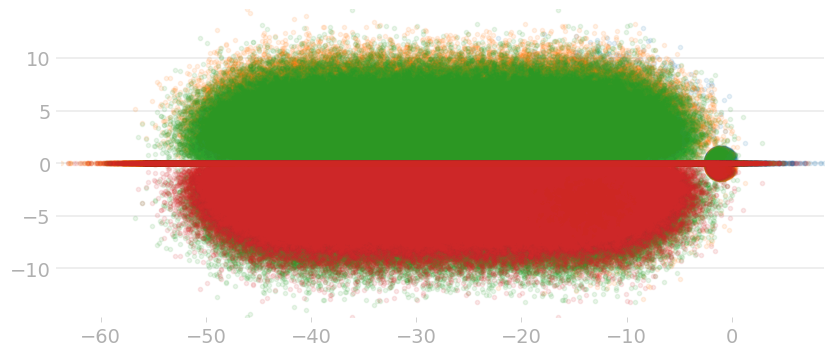

In [202]:
fig = plt.figure(figsize=(12,4))
ax = fig.subplots() 
circle1 = plt.Circle((-1, 0), 1.5, color='y', alpha=.2)
ax.add_patch(circle1)

# xs = np.real(eigen_values)
# ys = np.imag(eigen_values)
# ax.scatter(xs, ys, alpha=.2)

for i in range(4):
    xs = np.real(all_eigens[:, i])
    ys = np.imag(all_eigens[:, i])
    
    ax.scatter(xs, ys, 
               marker='.', alpha=.1)

    
ax.set_aspect('equal', adjustable='box')